In [1]:
!pwd

/home/lyp/Documents/elements of statistical learning


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from IPython.display import Latex
sns.set()

In [3]:
!ls

ch2.ipynb  ch3.ipynb  prostate.data  prostate.txt


In [4]:
df = pd.read_table("./prostate.txt",index_col=0)


In [5]:
data =np.array(df.values)
print('data.shape ',data.shape)
label =['Intercept','lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45','lpsa']

mask =data[:,-1]

data.shape  (97, 10)


In [6]:
mask =(mask=='T')
data =np.array(data[:,:-1],dtype='float32')
content =pd.DataFrame(data,columns=['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45','lpsa'])

In [2]:

print('data.shape ',data.shape)
X =np.array(data[:,:-1],dtype='float32')
y =np.array(data[:,-1],dtype='float32')



NameError: name 'data' is not defined

In [8]:
X_train =X[mask]
y_train =y[mask]
X_test  =X[~mask]
y_test  =y[~mask]
X_mean =X.mean(axis=0)
X_cov  =np.cov(X.T)

In [35]:
class ols:
    def __init__(self,mean=None,cov=None):
        self.mean=mean
        self.cov =cov
        self.intercept=None
        self.beta =None
        self.zscore=None
        self.loss =None
        self.RSS=None
        self.diags =None
    
    def fit(self,X,y,standard=0,mean=None,cov=None):
        Xs =X.copy()
        ys =y.copy()
        [N,p]=Xs.shape
        if(standard==1):
            self.mean=mean
            self.cov =cov
        
        """
        standardization
        """
        [N,p]=X.shape
        Xs =X.copy()
        ys =y.copy()
        Xs =Xs-self.mean[np.newaxis,:]
        std =np.sqrt(np.array(self.cov.diagonal(),dtype=float))
        Xs =Xs/std[np.newaxis,:]
        
        #print('Xs pinv \r\n ',np.linalg.pinv(Xs))
        Xs =np.concatenate([np.ones((N,1),dtype=float),Xs],axis=1)
        #print('[1 Xs] pinv \r\n ',np.linalg.pinv(Xs))
        diags =np.array(np.linalg.inv(Xs.T.dot(Xs)).diagonal(),dtype=float)
        diags =np.sqrt(diags)
        self.diags=diags
 
        betas =np.linalg.pinv(Xs).dot(y[:,np.newaxis])
        self.beta =betas[1:,0]
        self.intercept =betas[0,0]
        
        
        
        RSS=np.sum(np.square(Xs.dot(betas)-y[:,np.newaxis]))
        self.RSS=RSS
        self.loss =RSS/N
        theta =np.sqrt(RSS/(N-p-1))
        print('diags ',diags)
        print('thetas ',theta)
        self.zscore =betas[:,0]/(theta*diags)
        
        
        return [self.intercept,self.beta]
    def predict(self,X):
        Xs =X.copy()
        Xs =Xs-self.mean[np.newaxis,:]
        std =np.sqrt(np.array(self.cov.diagonal(),dtype=float))
        Xs =Xs/std[np.newaxis,:]
        return (Xs.dot(self.beta)+self.intercept*(np.ones((Xs.shape[0],1),dtype=float)))
    
    def fit_orthgo(self,X,y,index):
        [N,p] =X.shape
        Xs =X.copy()
        ys =y.copy()
        Xs =Xs-self.mean[np.newaxis,:]
        std =np.sqrt(np.array(self.cov.diagonal(),dtype='float32'))
        Xs =Xs/std[np.newaxis,:]
        Xs[:,[index,p-1]]=Xs[:,[p-1,index]]
        Z =np.ones((N,p+1),dtype='float32')
        gamma =np.zeros((p+1,p+1),dtype='float32')
        for i in range(p+1):
            if(i==0):
                continue
            for j in range(i):
                gamma[i,j]=np.dot(Xs[:,i-1],Z[:,j])/np.dot(Z[:,j],Z[:,j])
                Xs[:,i-1] =Xs[:,i-1]-gamma[i,j]*Z[:,j]
            Z[:,i]=Xs[:,i-1]
        
        beta =np.dot(Z[:,p],ys)/np.dot(Z[:,p],Z[:,p])
        return beta
    
    def fit_selection(self,X,y,indexs):
        if(X.ndim==1):
            X =X[:,np.newaxis]
        [N,p]=X.shape
        Xs =X.copy()
        ys =y.copy()
        
        Xs_mean =self.mean[indexs]
        #print('Xs_mean ',Xs_mean)
        Xs_cov  =self.cov[indexs,:]
        #print('Xs_cov ',Xs_cov)
        if(p==1):
            Xs_cov =Xs_cov[:,indexs]
            Xs =Xs-Xs_mean
            #print('Xs_cov.shape ',Xs_cov.shape)
            std =np.sqrt(np.array(Xs_cov,dtype=float))
            Xs =Xs/std
        else:
            Xs_cov  =Xs_cov[:,indexs]
            Xs =Xs-Xs_mean[np.newaxis,:]
            std =np.sqrt(np.array(Xs_cov.diagonal(),dtype=float))
            Xs =Xs/std[np.newaxis,:]
        
        

        
        
        
        Xs =np.concatenate([np.ones((N,1),dtype=float),Xs],axis=1)
        diags =np.array(np.linalg.inv(Xs.T.dot(Xs)).diagonal(),dtype=float)
        diags =np.sqrt(diags)
        
 
        betas =np.linalg.pinv(Xs).dot(ys[:,np.newaxis])
        beta=betas[1:,0]
        intercept =betas[0,0]
        
        
        
        RSS=np.sum(np.square(Xs.dot(betas)-ys[:,np.newaxis]))
        RSS=RSS
        loss =RSS/N
        theta =np.sqrt(RSS/(N-p-1))
        #print('diags ',diags)
        #print('thetas ',theta)
        zscore =betas[:,0]/(theta*diags)
        
        return [intercept,beta,loss,zscore]
    def best_subset(self,X_train,y_train):
        [N,p]=X_train.shape
        features =np.array(range(p),dtype=int)
        
        totals =pow(2,p);
        contents =np.zeros((totals,2),dtype=float)
        indexs   =np.zeros((totals,p),dtype=float)
        
        res =self.fit_selection(X_train[:,[]],y_train,[])
        contents[0,0]=0
        contents[0,1]=res[2]
        indexs[0,:]=0*(features)
        start =1;
        end =0;
        
        for i in range(p):
            for index in itertools.combinations(features,i+1):
                #print('index')
                index =np.array((index),int)
                #print(index)
                
                indexs[start,index] =1
                
                res =self.fit_selection(X_train[:,index],y_train,index)
                contents[start,0]=(i+1)
                contents[start,1]=res[2]
                start =start+1
        return[indexs,contents]
    
    def forward_stepwise(self,X_train,y_train):
        [N,p]=X_train.shape
        indexs =np.zeros((p+1,),dtype=int)
        contents =np.zeros((p+1,1),dtype=float)
        
        indexs[0]=0
        res =self.fit_selection(X_train[:,[]],y_train,[])
        contents[0,0]=res[2]
        
        choices =np.zeros((p,),dtype=int)
        min_index =-1;
        min_val =99999.0
        for l in range(p):
            l =l+1
            min_val =99999.0
            min_index =-1
            for i in range(p):
                if(choices[i]==0):
                    choices[i]=1
                    mask =np.nonzero(choices)[0]
                    #print('mask ',mask)
                    res =self.fit_selection(X_train[:,mask],y_train,mask)
                    if(min_val>res[2]):
                        min_val =res[2]
                        min_index =i
                    choices[i]=0
            indexs[l]=min_index+1
            contents[l,0]=min_val
            choices[min_index]=1
        
        return[indexs,contents]
    
    def  backward_stepwise(self,X_train,y_train):
        [N,p]=X_train.shape
        indexs =np.zeros((p+1,),dtype=int)
        contents =np.zeros((p+1,1),dtype=float)
        choices =np.ones((p,),dtype=int)
        items =np.array((range(p)),dtype=int)
        

        for l in range(p+1):
            l =p-l
            
            items =np.nonzero(choices)[0]
            res =self.fit_selection(X_train[:,items],y_train,items)
            contents[l]=res[2]
            #print(res[3])
            if(l==0):
                break
            index =items[np.argmin(np.abs(res[3]))-1]
            indexs[l]=index+1
            choices[index]=0            
        return[indexs,contents]
    
    def forward_stagewise(self,X_train,y_train):
        [N,p]=X_train.shape
        steps =0
        eps =0.0001
        intercept_val =0.0
        intercept =0.0
        betas_val =np.zeros((p,),dtype=float)
        betas     =np.zeros((p,),dtype=float)
        
        r =np.zeros((N,),dtype=float)
        new_r =np.zeros((N,),dtype=float)
        
        corrs =np.ones((p+1,),dtype=float)
        items =np.array(range(p),dtype=int)
        contents =np.zeros((p+1,),dtype=float)
        
        intercept_val=np.mean(y_train)
        
        
        intercept =intercept+intercept_val
        r =y_train-intercept
        new_r =r
        
        Xs =X_train.copy()
        ys =y_train.copy()
        Xs =Xs-self.mean[np.newaxis,:]
        std =np.sqrt(np.array(self.cov.diagonal(),dtype=float))
        Xs =Xs/std[np.newaxis,:]
        Xs_norm =np.zeros((p,),dtype=float)
        
        ones =np.ones((N,),dtype=float)

        corrs[0]=np.dot(ones,r)
        corrs[0] =corrs[0]/(np.linalg.norm(ones,ord=2)*np.linalg.norm(r,ord=2))
        for i in range(p):
            Xs_norm[i]=np.linalg.norm(Xs[:,i],ord=2)
            corrs[i+1] =np.dot(r,Xs[:,i])/(np.linalg.norm(r,ord=2)*Xs_norm[i])
        
        
        while(np.linalg.norm(corrs,ord=np.inf)>eps):
            steps =steps+1
            index =np.argmax(np.abs(corrs))
            
            #print('steps ',steps)
            #print('corrs ',corrs)
            #print('index ',index)
            l =len(np.nonzero(betas)[0])
            #print('l ',l)
            contents[l]=np.sum(np.square(r))
            
            if(index==0):
                intercept_val =np.dot(r,ones)/np.square(np.linalg.norm(ones,ord=2))
                intercept =intercept+intercept_val
            else:
                betas_val[index-1] =np.dot(r,Xs[:,index-1])/np.square(Xs_norm[index-1])
                #print('before r ',np.linalg.norm(r))
                #print('np.dot(r,Xs[:,index-1]) ',np.dot(r,Xs[:,index-1]))
                #print('Xs_norm[index-1] ',Xs_norm[index-1])
                #print('beta ',betas_val[index-1])
                #print('before  r ',)
                #print('r ',np.linalg.norm(r))
                #print('delta beta ',betas_val[index-1])
                #print('$$$ ')
                #print(np.linalg.norm(ys-(np.dot(Xs,betas[:,np.newaxis])+intercept)[:,0]))
                
                betas[index-1] =betas[index-1]+betas_val[index-1]
            
            new_r =new_r -betas_val[index-1]*Xs[:,index-1] #not numerical stable
            #print('new_r ',np.linalg.norm(new_r))
            #r should be updated by this not the above 
            r = ys -(np.dot(Xs,betas[:,np.newaxis])+intercept)[:,0]  #stable
            #print('after r ')
            #print('r ',np.linalg.norm(r))
  
            #print('delta r ',np.linalg.norm(r-new_r))
            corrs[0]=np.dot(ones,r)
            corrs[0] =corrs[0]/(np.linalg.norm(ones,ord=2)*np.linalg.norm(r,ord=2))
            for i in range(p):
                corrs[i+1] =np.dot(r,Xs[:,i])/(np.linalg.norm(r,ord=2)*Xs_norm[i])
        
        print('steps ',steps)
        #print('intercept ',intercept)
        #print('betas ',betas)
        #print('corrs ',corrs)
        #print('changed ')
        

        
        return [steps,contents]
    
    def ridge_regression(self,X,y,alpha=0.05):
 
        [N,p]=X.shape
        #print('X shape ',X.shape)
        Xs =X.copy()
        ys =y.copy()
        intercept =ys.mean()
        ys =ys-intercept
        
        Xs =Xs-self.mean[np.newaxis,:]
        std =np.sqrt(np.array(self.cov.diagonal(),dtype=float))
        Xs =Xs/std[np.newaxis,:]
        
        

        
        
        
        U,D,V_T =np.linalg.svd(Xs)
        #print('U shape ',U.shape)
        #print('D shape ',D.shape)
        #print('V_T shape ',V_T.shape)
        df =0.0
        for i in range(min(p,D.shape[0])):
            df = df +(np.square(D[i]))/(np.square(D[i])+alpha)
        
        temp =np.linalg.inv(Xs.T.dot(Xs)+alpha*np.eye(p))
        temp =temp.dot(Xs.T)
        #print('norm error ',np.linalg.norm((np.linalg.pinv(Xs))-temp))
        
        beta =temp.dot(ys[:,np.newaxis])
        return [intercept,beta,df]
    
    def lar(self,X,y):
        [N,p]=X.shape
        Xs =X.copy()
        ys =y.copy()
        
        intercept =ys.mean()
        Xs =Xs-self.mean[np.newaxis,:]
        std =np.sqrt(np.array(self.cov.diagonal(),dtype=float))
        Xs =Xs/std[np.newaxis,:]
        
        Xs =Xs -Xs.mean(axis=0)[np.newaxis,:]
        for i in range(p):
            Xs[:,i] =Xs[:,i]/np.linalg.norm(Xs[:,i])
        
        features =np.array(range(p),dtype=int)
        records  =(-1)*np.ones((p,),dtype=int)
        activates =np.zeros((N,p),dtype=float)
        betas =[]
        steps =[]
        
        max_corrs =-1
        max_index =-1
        max_step=0.0
        next_dir =0.0
        cur_dir =0.0
        base_dir =np.array([0.0],dtype=float)
        
        ys =ys -intercept
        r=ys
        r =r.reshape((N,1))
        last_index =-1
        for i in range(p):
            if(i==0):
                corrs =Xs.T.dot(r)
                index =np.argmax(np.abs(corrs))
                features[index]=-1
                records[i]=index
                activates[:,i]=Xs[:,index]
                base_dir =0.0
                next_dir =activates[:,i].dot(r.reshape((N,)))
                last_index =index
                continue
            
            cur_dir=next_dir
            mask =(features!=-1)
            inactivate_choices =features[mask]
            l =len(inactivate_choices)
            
            max_corrs =-99999.0
            max_index =-1
            max_step =0.0
            A1=0
            A2=0
            B1=0
            B2=0
            C1=0
            C2=0
            D1=0
            D2=0
            for j in range(l):
                index =inactivate_choices[j]
                A1 =activates[:,i-1].dot(r.reshape((N,)))
                B1 =Xs[:,index].dot(r.reshape((N,)))
                
                if(i==1):
                    A2 = activates[:,0].dot((cur_dir*activates[:,0]))
                    B2 =Xs[:,index].dot((cur_dir*activates[:,0]))
                else:
                    A2 =activates[:,i-1].dot(((activates[:,:i].dot(cur_dir))).reshape((N,)))
                    B2 =Xs[:,index].dot(((activates[:,:i].dot(cur_dir))).reshape((N,)))
                
                C1 =(A1-B1)/(A2-B2)
                C2 =(A1+B1)/(A2+B2)
                print('index ',index)
                print(' C1 ',C1)
                print(' C2 ',C2)
                if(C1>=0 and C1<=1):
                    D1=A1-C1*A2
                    if(max_corrs<np.abs(D1)):
                        max_corrs =np.abs(D1)
                        max_index =index
                        max_step =C1
                        
                if(C2>=0 and C2<=1):
                    D1=A1-C2*A2
                    if(max_corrs<np.abs(D1)):
                        max_corrs =np.abs(D1)
                        max_index =index
                        max_step =C2
            
            if(max_index==-1):
                print('error')
                break
            features[max_index]=-1
            records[i]=max_index
            
            activates[:,i]=Xs[:,max_index]
            base_dir =base_dir +max_step*cur_dir
            base_dir =base_dir.reshape((i,))
            print('base_dir.shape ',base_dir.shape)
            print('base_dir ',base_dir)
            
            if(i==1):
                base_dir =np.concatenate([base_dir,[0]])
                base_dir =base_dir.reshape((i+1,1))
                r =ys[:,np.newaxis] -activates[:,:i+1].dot(base_dir)
            else:
                base_dir=np.concatenate([base_dir.reshape((i,)),[0]])
                base_dir =base_dir.reshape((i+1,1))
                r =ys[:,np.newaxis] -activates[:,:i+1].dot(base_dir)
            
            next_dir =np.linalg.pinv((activates[:,:i+1])).dot(r)
            
            betas.append(base_dir)
            steps.append(max_step)
            
        cur_dir =next_dir
        max_step =activates[:,-2].dot(r)/(activates[:,-2].dot(((activates.dot(cur_dir))).reshape((N,))))
        base_dir =base_dir +max_step*cur_dir
        betas.append(base_dir)
        steps.append(max_step)
        return [records,betas,steps]
    
    
    
    def lar_lasso(self,X,y):
        [N,p]=X.shape
        Xs =X.copy()
        ys =y.copy()
        
        intercept =ys.mean()
        Xs =Xs-self.mean[np.newaxis,:]
        std =np.sqrt(np.array(self.cov.diagonal(),dtype=float))
        Xs =Xs/std[np.newaxis,:]
        
        Xs =Xs -Xs.mean(axis=0)[np.newaxis,:]
        for i in range(p):
            Xs[:,i] =Xs[:,i]/np.linalg.norm(Xs[:,i])
        
        features =np.array(range(p),dtype=int)
        records  =(-1)*np.ones((p,),dtype=int)
        activates =np.zeros((N,p),dtype=float)
        betas =[]
        steps =[]
        
        max_corrs =-1
        max_index =-1
        max_step=0.0
        next_dir =0.0
        cur_dir =0.0
        base_dir =np.array([0.0],dtype=float)
        
        ys =ys -intercept
        r=ys
        r =r.reshape((N,1))
        last_index =-1
        eps =0.0001
        
        corrs =Xs.T.dot(r)
        step =-1
        i =0
        while(i<p):
            step =step+1
            if(i==0):
                corrs =Xs.T.dot(r)
                index =np.argmax(np.abs(corrs))
                features[index]=-1
                records[i]=index
                activates[:,i]=Xs[:,index]
                base_dir =0.0
                next_dir =activates[:,i].dot(r.reshape((N,)))
                last_index =index
                i=i+1
                continue
            
            cur_dir=next_dir
            mask =(features!=-1)
            inactivate_choices =features[mask]
            l =len(inactivate_choices)
            
            max_corrs =-99999.0
            max_index =-1
            max_step =0.0
            A1=0
            A2=0
            B1=0
            B2=0
            C1=0
            C2=0
            D1=0
            D2=0
            for j in range(l):
                index =inactivate_choices[j]
                A1 =activates[:,i-1].dot(r.reshape((N,)))
                B1 =Xs[:,index].dot(r.reshape((N,)))
                
                if(i==1):
                    A2 = activates[:,0].dot((cur_dir*activates[:,0]))
                    B2 =Xs[:,index].dot((cur_dir*activates[:,0]))
                else:
                    A2 =activates[:,i-1].dot(((activates[:,:i].dot(cur_dir))).reshape((N,)))
                    B2 =Xs[:,index].dot(((activates[:,:i].dot(cur_dir))).reshape((N,)))
                
                C1 =(A1-B1)/(A2-B2)
                C2 =(A1+B1)/(A2+B2)
                print('index ',index)
                print(' C1 ',C1)
                print(' C2 ',C2)
                if(C1>=0 and C1<=1):
                    D1=A1-C1*A2
                    if(max_corrs<np.abs(D1)):
                        max_corrs =np.abs(D1)
                        max_index =index
                        max_step =C1
                        
                if(C2>=0 and C2<=1):
                    D1=A1-C2*A2
                    if(max_corrs<np.abs(D1)):
                        max_corrs =np.abs(D1)
                        max_index =index
                        max_step =C2
            
            if(max_index==-1):
                print('error')
                break
                
            cross_zero =0
            zeros =-1*(base_dir/cur_dir)
            zeros =zeros.reshape((i,))
            zeros_index =-1
            zeros_val =99999.0
            print('base_dir ',base_dir)
            print('cur_dir ',cur_dir)
            print('zeros ',zeros)
            print('len(zeros) ',len(zeros))
            for m in range(len(zeros)):
                if(zeros[m]>0  and zeros[m]<max_step and zeros[m]<zeros_val):
                    zeros_val =zeros[m]
                    zeros_index =m
            if(zeros_index!=-1):
                features[records[m]]=records[m]
                activates[:,m:i]=activates[:,m+1:i+1]
                records[m:i]=records[m+1:i+1]
                base_dir =base_dir + zeros_val*cur_dir
                base_dir =base_dir.reshape((i-1,1))
                
                r =ys[:,np.newaxis] -activates[:,:i-1].dot(base_dir)
                next_dir =np.linalg.pinv((activates[:,:i-1])).dot(r)
                betas.append(base_dir)
                steps.append(zeros_val)
                i=i-1
                continue
                
                
                
            
            features[max_index]=-1
            records[i]=max_index
            
            activates[:,i]=Xs[:,max_index]
            base_dir =base_dir +max_step*cur_dir
            base_dir =base_dir.reshape((i,))
            print('base_dir.shape ',base_dir.shape)
            print('base_dir ',base_dir)
            
            if(i==1):
                base_dir =np.concatenate([base_dir,[0]])
                base_dir =base_dir.reshape((i+1,1))
                r =ys[:,np.newaxis] -activates[:,:i+1].dot(base_dir)
            else:
                base_dir=np.concatenate([base_dir.reshape((i,)),[0]])
                base_dir =base_dir.reshape((i+1,1))
                r =ys[:,np.newaxis] -activates[:,:i+1].dot(base_dir)
            
            next_dir =np.linalg.pinv((activates[:,:i+1])).dot(r)
            
            betas.append(base_dir)
            steps.append(max_step)
            i=i+1
            
            
        cur_dir =next_dir
        max_step =activates[:,-2].dot(r)/(activates[:,-2].dot(((activates.dot(cur_dir))).reshape((N,))))
        base_dir =base_dir +max_step*cur_dir
        betas.append(base_dir)
        steps.append(max_step)
        return [records,betas,steps]
                
        
    def pcr(self,X,y,m):
        [N,p]=X.shape
        Xs =X.copy()
        ys =y.copy()
        
        r =np.linalg.matrix_rank(Xs)
        if(m>r):
            m=r
        intercept =ys.mean()
        Xs =Xs-self.mean[np.newaxis,:]
        std =np.sqrt(np.array(self.cov.diagonal(),dtype=float))
        Xs =Xs/std[np.newaxis,:]
        Xs =Xs -Xs.mean(axis=0)[np.newaxis,:]
        for i in range(p):
            Xs[:,i] =Xs[:,i]/np.linalg.norm(Xs[:,i])
        
        theta =np.zeros((m,),dtype=float)
        [U, S, V] =np.linalg.svd(Xs)
        
        Z =Xs.dot(V)
        for i in range(m):
            theta[i] =np.dot(ys,Z[:,i])/(np.dot(Z[:,i],Z[:,i]))
        beta =np.sum(np.multiply(theta[np.newaxis,:],V[:,:m]),axis=1)
        
        return [intercept,beta]
    
    def pls(self,X,y):
        [N,p]=X.shape
        Xs =X.copy()
        ys =y.copy()
        intercept =ys.mean()
        Xs =Xs-self.mean[np.newaxis,:]
        std =np.sqrt(np.array(self.cov.diagonal(),dtype=float))
        Xs =Xs/std[np.newaxis,:]
        Xs =Xs -Xs.mean(axis=0)[np.newaxis,:]
        for i in range(p):
            Xs[:,i] =Xs[:,i]/np.linalg.norm(Xs[:,i])
        
        y_val =np.zeros((N,p+1),dtype=float)
        y_val[:,0]=intercept
        theta =np.zeros((p,),dtype=float)
        for i in range(1,p+1):
            coes =np.dot(ys[np.newaxis,:],Xs)
            z =np.dot(Xs,coes.T)
            theta[i-1] =np.dot(z[:,],ys)/np.dot(z[:,],z[:,])
            y_val[i] =y_val[i-1] +theta[i-1]*z
            
            for j in range(p):
                Xs[:,i] =Xs[:,i] -(np.dot(Xs[:,i],z[:,])/np.dot(z[:,],z[:,]))*z[:,]
        
        return [theta,y_val]
    
    def FS_eps(self,X,y,eps,tol):
        [N,p]=X.shape
        Xs =X.copy()
        ys =y.copy()
        intercept =ys.mean()
        Xs =Xs-self.mean[np.newaxis,:]
        std =np.sqrt(np.array(self.cov.diagonal(),dtype=float))
        Xs =Xs/std[np.newaxis,:]
        Xs =Xs -Xs.mean(axis=0)[np.newaxis,:]
        for i in range(p):
            Xs[:,i] =Xs[:,i]/np.linalg.norm(Xs[:,i])
        
        beta =np.zeros((p,),dtype=float)
        r =ys.copy()
        corrs =np.dot(r[np.newaxis,:],Xs)
        records =[]
        records.append(beta)
        while(np.linalg.norm(corrs)>tol):
            index =np.argmax(abs(corrs))
            theta =np.sign(np.dot(ys,Xs[:,index]))
            beta =bata[index]+theta*eps
            records.append(beta)
            r =r -theta*Xs[:,index]
            corrs =np.dot(r[np.newaxis,:],Xs)
        return records
    
    
    
            
            
            
        
        
    
    
    
            
        
    
   
        
            
            
            
            
            
                
                
                
                
                
                
            
                
            
        
        
            
            
            
                
               
                
                
            
            
        
        
            
            
            
            
            
            
        
        
        
        
        
        
 
    
                 
                      
            


    
        
                
            
        
        
    
        
        
                
            
        

In [19]:

ls =ols(X_mean,X_cov)
[N,p0]=X_train.shape
[intercept,beta]=ls.fit(X_train,y_train)
ols_betas =beta

print('loss ',ls.loss)
print('intercept ',intercept)
print('beta ',beta)
print('zscore ',ls.zscore)
RSS0 =ls.RSS
drop_features =np.argsort(np.abs(ls.zscore))
drop_mask =drop_features[4:-1]-1
print('drop_features ',drop_features)
print('drop_mask ',drop_mask)
[N,p1]=X_train[:,drop_mask].shape
X_mean2 =np.mean(X[:,drop_mask],axis=0)
X_cov2  =np.cov(X[:,drop_mask].T)
ls2 =ols(X_mean2,X_cov2)
ls2.fit(X_train[:,drop_mask],y_train)
RSS1 =ls2.RSS
print('RSS0 ',RSS0)
print('RSS1 ',RSS1)
print('N ',N)
print('p0 ',p0)
print('p1 ',p1)
F_score =((RSS1-RSS0)/(p0-p1))/(RSS0/(N-p0-1))
print('F score ',F_score)

import scipy.stats as stats
p_value =stats.f.sf(F_score,p0-p1,N-p0-1)
print('p_value ',p_value)


diags  [0.12539201 0.17777833 0.13425534 0.14227773 0.1435084  0.17352616
 0.21694842 0.20391699 0.21566274]
thetas  0.7122860825147475
loss  0.43919977423826756
intercept  2.4649329890018596
beta  [ 0.67952816  0.26305306 -0.14146483  0.21014656  0.30520058 -0.28849276
 -0.02130504  0.26695573]
zscore  [27.59820293  5.36629055  2.75078933 -1.39590898  2.05584562  2.469255
 -1.86691252 -0.14668122  1.73783953]
drop_features  [7 3 8 6 4 5 2 1 0]
drop_mask  [3 4 1 0]
diags  [0.12234819 0.1404148  0.15548186 0.12997138 0.14995954]
thetas  0.7275122735560633
RSS0  29.426384873963926
RSS1  32.81499470683216
N  67
p0  8
p1  4
F score  1.6697546364270943
p_value  0.16933713111208903


[1. 1. 1. 1. 1. 1. 1. 1.]
[8.         0.43919977]
min_loss  [[93.40737277]
 [42.53476525]
 [34.87740655]
 [32.30269286]
 [29.87633846]
 [28.71890825]
 [26.89323783]
 [25.48303646]
 [25.03438713]]


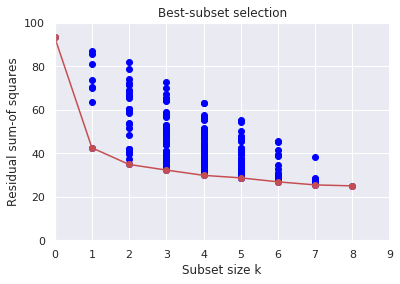

In [20]:
[indexs,contents]=ls.best_subset(X_train,y_train)
print(indexs[-1,:])
print(contents[-1,:])
[N,p]=X_train.shape
contents[:,1]=np.multiply(contents[:,1],N-2-contents[:,0])
min_loss =np.zeros((p+1,1),dtype=float)
for i in range(p+1):
    mask =(contents[:,0]==i)
    min_loss[i]=np.min(contents[mask][:,1])
print('min_loss ',min_loss)

plt.xlim(0,p+1)
plt.ylim(0,100)
plt.title('Best-subset selection')
plt.ylabel('Residual sum-of squares')
plt.xlabel('Subset size k')
plt.plot(contents[:,0],contents[:,1],'o',color='blue')
plt.plot(np.array(range(p+1)),min_loss,'-or')

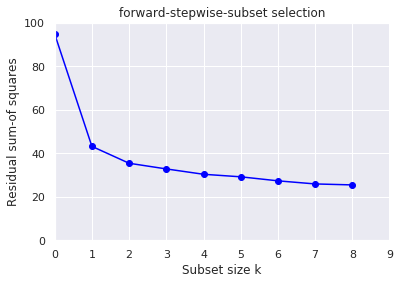

In [21]:
[indexs,contents]=ls.forward_stepwise(X_train,y_train)
for i in range(len(contents)):
    contents[i]=contents[i]*(N-i-1)
plt.xlim(0,p+1)
plt.ylim(0,100)
plt.title('forward-stepwise-subset selection')
plt.ylabel('Residual sum-of squares')
plt.xlabel('Subset size k')
plt.plot(np.array(range(p+1),dtype=float),contents[:,0],'-or',color='blue')


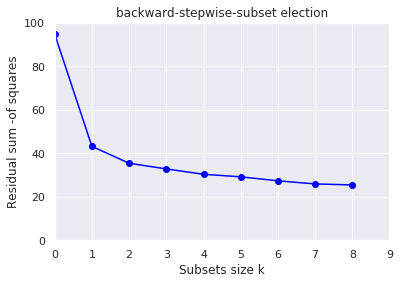

In [22]:
[indexs,contents]=ls.backward_stepwise(X_train,y_train)
for i in range(len(contents)):
    contents[i]=contents[i]*(N-i-1)

plt.xlim(0,p+1)
plt.ylim(0,100)
plt.title('backward-stepwise-subset election')
plt.xlabel('Subsets size k')
plt.ylabel('Residual sum -of squares')
plt.plot(np.array(range(p+1),dtype=float),contents,'-or',color='blue')

/root/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


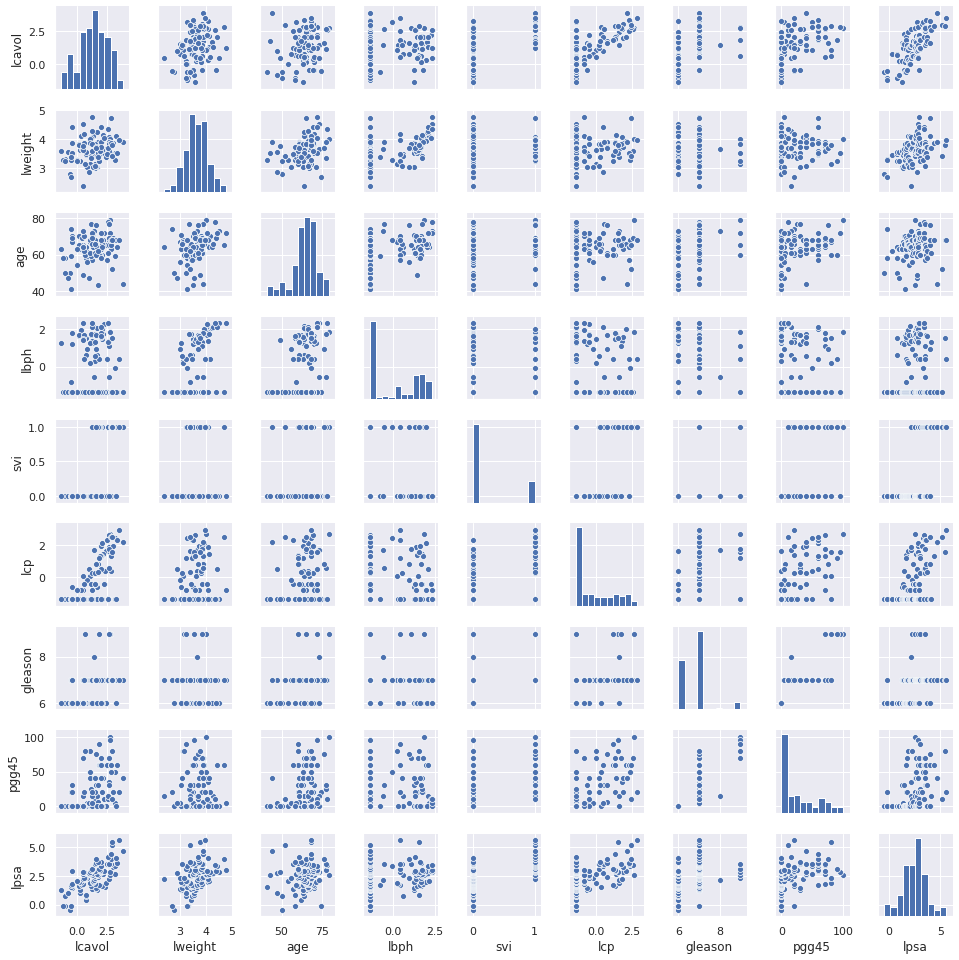

In [23]:
sns.pairplot(content,size=1.5)

steps  92
contents.shape  (9,)
np.array(range(p+1),dtype=float)  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
contents  [96.28144836 44.57391814 37.80455842 36.83594215 36.03397898 33.80216307
 32.50847122 29.45245524 29.4263893 ]


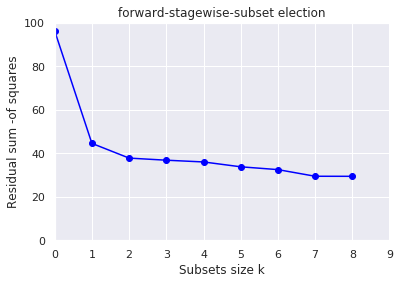

In [24]:
[steps,contents]=ls.forward_stagewise(X_train,y_train)
print('contents.shape ',contents.shape)

plt.xlim(0,p+1)
plt.ylim(0,100)
plt.title('forward-stagewise-subset election')
plt.xlabel('Subsets size k')
plt.ylabel('Residual sum -of squares')
print('np.array(range(p+1),dtype=float) ',np.array(range(p+1),dtype=float))
print('contents ',contents)
plt.plot(np.array(range(p+1),dtype=float),contents,'-or',color='blue')

In [25]:
np.linalg.norm((np.ones((4,),dtype=float)),ord=2)

2.0

In [26]:
[intercept,beta,df]=ls.ridge_regression(X_train,y_train,alpha=0)
print('intercept ',intercept)
print('beta ',beta)
print('effective degree of freedom ',df)
[N,p]=X_train.shape

print('ols ',ls.fit(X_train,y_train))

intercept  2.4523451
beta  [[ 0.67912151]
 [ 0.26265894]
 [-0.1393084 ]
 [ 0.20963901]
 [ 0.30568633]
 [-0.29004887]
 [-0.02432797]
 [ 0.27027467]]
effective degree of freedom  8.0
diags  [0.12539201 0.17777833 0.13425534 0.14227773 0.1435084  0.17352616
 0.21694842 0.20391699 0.21566274]
thetas  0.7122860825147475
ols  [2.4649329890018596, array([ 0.67952816,  0.26305306, -0.14146483,  0.21014656,  0.30520058,
       -0.28849276, -0.02130504,  0.26695573])]


lines  ['-g', '-b', '-r', '-y', '-c', '-m', '--g', '-w']
label  ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45', 'lpsa']


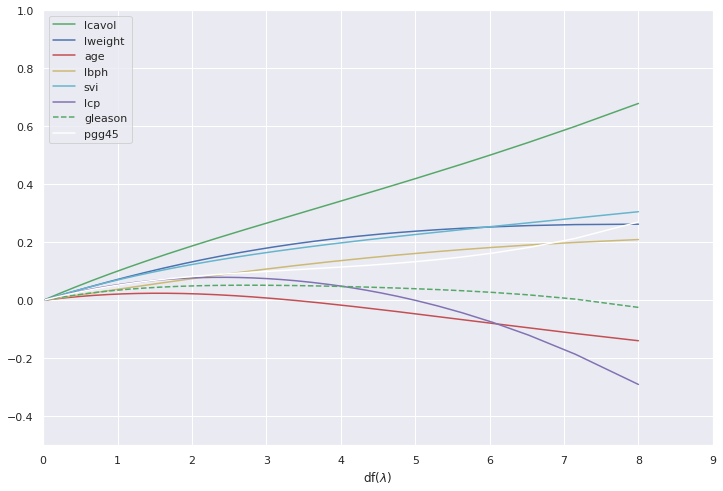

In [27]:
alphas =np.linspace(0,20000,5000)
coefficents =np.zeros((5000,p),dtype=float)
df_arrs     =np.zeros((5000,),dtype=float)
for i in range(5000):
    [intercept,beta,df] =ls.ridge_regression(X_train,y_train,alphas[i])
    #print('coefficents[i].shape ',coefficents[i,:].shape) 
    #print('beta.shape ',beta.reshape(p,).shape)
    coefficents[i]=beta.reshape((p,))
    df_arrs[i]=df

plt.figure(figsize=(12,8))
plt.xlim(0,9)
plt.ylim(-0.5,1)
plt.xlabel("df($\lambda$)")
lines =['-g','-b','-r','-y','-c','-m','--g','-w']
label =['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45','lpsa']
print('lines ',lines)
print('label ',label)

for i in range(p):
    plt.plot(df_arrs,coefficents[:,i],lines[i],label=label[i])
plt.legend()



In [28]:
[records,betas,steps] =ls.lar(X_train,y_train)

index  1
 C1  0.48327744833512787
 C2  1.2780933765997333
index  2
 C1  0.9661294383506942
 C2  1.0187919938049002
index  3
 C1  0.6846065823615265
 C2  1.2779154461970654
index  4
 C1  0.590650662105709
 C2  1.1046022141761314
index  5
 C1  1.0804842376389046
 C2  0.9853516266657125
index  6
 C1  0.929136322751354
 C2  1.0284955177215673
index  7
 C1  0.7524148151843542
 C2  1.0862762428737518
base_dir.shape  (1,)
base_dir  [3.47667204]
index  2
 C1  1.2437434260851228
 C2  0.9107151280102824
index  3
 C1  0.5932388288686798
 C2  1.1807435750899644
index  4
 C1  0.20899399874683577
 C2  1.200676238237368
index  5
 C1  1.0253089566934745
 C2  0.9946845470545332
index  6
 C1  0.7568463605722344
 C2  1.1181254943340166
index  7
 C1  0.4711503572559833
 C2  1.2115058194200938
base_dir.shape  (2,)
base_dir  [4.07417158 0.59749954]
index  2
 C1  1.247662885415988
 C2  0.9031621756973213
index  3
 C1  0.41146971256790893
 C2  1.3356644664323425
index  5
 C1  1.945001294585609
 C2  0.90414338

In [29]:
#print('betas ',len(betas))
#print('records ',records)
coefficents =np.zeros((p,p+1),dtype=float)
L1_arc =np.zeros((p+1,),dtype=float)
for i in range(1,p+1):
    for j in range(betas[i-1].shape[0]):
        coefficents[records[j],i] =betas[i-1][j]
    L1_arc[i] =np.linalg.norm(betas[i-1],ord=1)
print('betas ',betas)

betas  [array([[3.47667204],
       [0.        ]]), array([[4.07417158],
       [0.59749954],
       [0.        ]]), array([[4.55765324],
       [1.52549361],
       [0.75518238],
       [0.        ]]), array([[4.56718114],
       [1.53528886],
       [0.78203088],
       [0.02907847],
       [0.        ]]), array([[4.70943776],
       [1.99543963],
       [1.6272385 ],
       [1.16580988],
       [0.73181761],
       [0.        ]]), array([[ 4.76423146],
       [ 2.08975763],
       [ 1.69165262],
       [ 1.33123885],
       [ 0.86641888],
       [-0.26067534],
       [ 0.        ]]), array([[ 5.68183618],
       [ 2.36407456],
       [ 2.43973081],
       [ 1.67537554],
       [ 1.99206596],
       [-1.0865453 ],
       [-2.08347824],
       [ 0.        ]]), array([[ 5.82011831],
       [ 2.3774381 ],
       [ 2.51536079],
       [ 1.72235794],
       [ 2.25316897],
       [-1.15807865],
       [-2.34789261],
       [-0.16990226]])]


lines  ['-g', '-b', '-r', '-y', '-c', '-m', '--g', '-w']
label  ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45', 'lpsa']


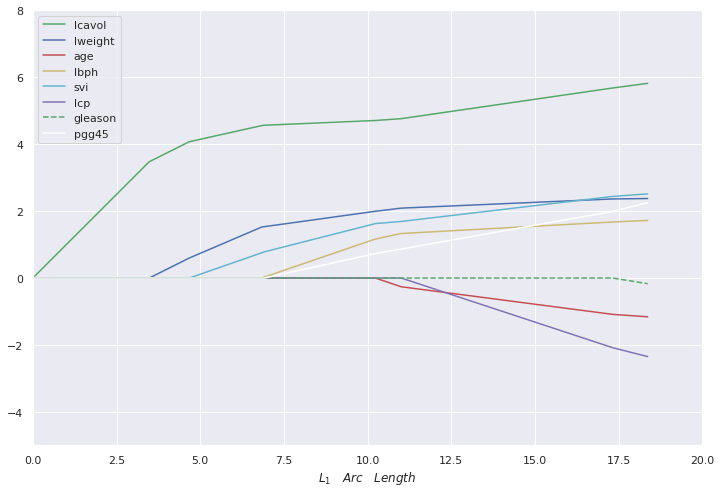

In [30]:
plt.figure(figsize=(12,8))
plt.xlim(0,20)
plt.ylim(-5,8)
plt.xlabel("$L_{1} \quad Arc \quad Length$")
lines =['-g','-b','-r','-y','-c','-m','--g','-w']
label =['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45','lpsa']
print('lines ',lines)
print('label ',label)

for i in range(p):
    plt.plot(L1_arc,coefficents[i,:],lines[i],label=label[i])
plt.legend()


In [31]:
ls.lar_lasso(X_train,y_train)

index  1
 C1  0.48327744833512787
 C2  1.2780933765997333
index  2
 C1  0.9661294383506942
 C2  1.0187919938049002
index  3
 C1  0.6846065823615265
 C2  1.2779154461970654
index  4
 C1  0.590650662105709
 C2  1.1046022141761314
index  5
 C1  1.0804842376389046
 C2  0.9853516266657125
index  6
 C1  0.929136322751354
 C2  1.0284955177215673
index  7
 C1  0.7524148151843542
 C2  1.0862762428737518
base_dir  0.0
cur_dir  7.193946357127602
zeros  [-0.]
len(zeros)  1
base_dir.shape  (1,)
base_dir  [3.47667204]
index  2
 C1  1.2437434260851228
 C2  0.9107151280102824
index  3
 C1  0.5932388288686798
 C2  1.1807435750899644
index  4
 C1  0.20899399874683577
 C2  1.200676238237368
index  5
 C1  1.0253089566934745
 C2  0.9946845470545332
index  6
 C1  0.7568463605722344
 C2  1.1181254943340166
index  7
 C1  0.4711503572559833
 C2  1.2115058194200938
base_dir  [[3.47667204]
 [0.        ]]
cur_dir  [[2.85893158]
 [2.85893158]]
zeros  [-1.21607389 -0.        ]
len(zeros)  2
base_dir.shape  (2,)
bas

[array([0, 1, 4, 3, 7, 2, 5, 6]), [array([[3.47667204],
         [0.        ]]), array([[4.07417158],
         [0.59749954],
         [0.        ]]), array([[4.55765324],
         [1.52549361],
         [0.75518238],
         [0.        ]]), array([[4.56718114],
         [1.53528886],
         [0.78203088],
         [0.02907847],
         [0.        ]]), array([[4.70943776],
         [1.99543963],
         [1.6272385 ],
         [1.16580988],
         [0.73181761],
         [0.        ]]), array([[ 4.76423146],
         [ 2.08975763],
         [ 1.69165262],
         [ 1.33123885],
         [ 0.86641888],
         [-0.26067534],
         [ 0.        ]]), array([[ 5.68183618],
         [ 2.36407456],
         [ 2.43973081],
         [ 1.67537554],
         [ 1.99206596],
         [-1.0865453 ],
         [-2.08347824],
         [ 0.        ]]), array([[ 5.82011831],
         [ 2.3774381 ],
         [ 2.51536079],
         [ 1.72235794],
         [ 2.25316897],
         [-1.15807865],
   

In [32]:
ww =np.array([],dtype=float)
len(ww)

0

In [33]:
print(ww.shape)

(0,)


In [34]:
[intercept,beta]=ls.pcr(X_train,y_train,m=np.linalg.matrix_rank(X_train))
print('intercept ',intercept)
print('beta ',beta)

intercept  2.4523451
beta  [ 8.51294697  3.63183533  0.51609989  3.82141288  8.09801641 -0.67601731
  0.13802422  5.29255981]
